### 1. 导入相关包

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA

C:\ProgramData\Anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\ProgramData\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\ProgramData\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


### 2. 读取数据，简单进行处理

In [2]:
path = 'C:/Users/new/Desktop/Prediction-of-Containment-Events/数据/dataset.csv'
data = pd.read_csv(path)

In [3]:
data.head()

,日期,district,street,经停病例数,患者数量,全市患者数量,所在区患者数量,邻近地区1经停病例数,邻近地区2经停病例数,邻近地区3经停病例数,封控与否
0,2021/12/23 0:00,津南区,永胜道,31.0,0.0,0.0,0.0,1.0,0.0,0.0,0
1,2021/12/24 0:00,津南区,永胜道,42.0,0.0,0.0,0.0,2.0,0.0,3.0,0
2,2021/12/25 0:00,津南区,永胜道,36.0,0.0,0.0,0.0,2.0,0.0,4.0,0
3,2021/12/26 0:00,津南区,永胜道,46.0,0.0,0.0,0.0,4.0,2.0,3.0,0
4,2021/12/27 0:00,津南区,永胜道,73.0,0.0,0.0,0.0,4.0,2.0,2.0,0


In [4]:
data.drop(['district', 'street', '全市患者数量'], axis=1, inplace=True)
data.set_index('日期',inplace=True)

In [5]:
data.head()
data.info()

,经停病例数,患者数量,所在区患者数量,邻近地区1经停病例数,邻近地区2经停病例数,邻近地区3经停病例数,封控与否
日期,,,,,,,
2021/12/23 0:00,31.0,0.0,0.0,1.0,0.0,0.0,0
2021/12/24 0:00,42.0,0.0,0.0,2.0,0.0,3.0,0
2021/12/25 0:00,36.0,0.0,0.0,2.0,0.0,4.0,0
2021/12/26 0:00,46.0,0.0,0.0,4.0,2.0,3.0,0
2021/12/27 0:00,73.0,0.0,0.0,4.0,2.0,2.0,0


<class 'pandas.core.frame.DataFrame'>
Index: 34112 entries, 2021/12/23 0:00 to 2022/2/1 0:00
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   经停病例数       34112 non-null  float64
 1   患者数量        34112 non-null  float64
 2   所在区患者数量     34112 non-null  float64
 3   邻近地区1经停病例数  34112 non-null  float64
 4   邻近地区2经停病例数  34112 non-null  float64
 5   邻近地区3经停病例数  34112 non-null  float64
 6   封控与否        34112 non-null  int64  
dtypes: float64(6), int64(1)
memory usage: 2.1+ MB


### 3. 将数据处理成LSTM的数据输入格式：[batch_size, time_step, input_size]
在这里要注意，由于原始数据是所有street在 2021/12/23-2022/2/1 这段时间序列(length=41)的数据，不同street间的数据并没有时间上的相关性，因此需要划分为不同的样本

In [6]:
length = 41  # 每个镇区数据的时间序列长度都是41
split = int(len(data)*0.8) - int(len(data)*0.8) % length
train = data[:split]  # 相当于拿前面的大部分镇区数据做训练集，后面的小部分镇区做测试集了
test = data[split:]

In [7]:
train.head()
train.info()

,经停病例数,患者数量,所在区患者数量,邻近地区1经停病例数,邻近地区2经停病例数,邻近地区3经停病例数,封控与否
日期,,,,,,,
2021/12/23 0:00,31.0,0.0,0.0,1.0,0.0,0.0,0
2021/12/24 0:00,42.0,0.0,0.0,2.0,0.0,3.0,0
2021/12/25 0:00,36.0,0.0,0.0,2.0,0.0,4.0,0
2021/12/26 0:00,46.0,0.0,0.0,4.0,2.0,3.0,0
2021/12/27 0:00,73.0,0.0,0.0,4.0,2.0,2.0,0


<class 'pandas.core.frame.DataFrame'>
Index: 27265 entries, 2021/12/23 0:00 to 2022/2/1 0:00
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   经停病例数       27265 non-null  float64
 1   患者数量        27265 non-null  float64
 2   所在区患者数量     27265 non-null  float64
 3   邻近地区1经停病例数  27265 non-null  float64
 4   邻近地区2经停病例数  27265 non-null  float64
 5   邻近地区3经停病例数  27265 non-null  float64
 6   封控与否        27265 non-null  int64  
dtypes: float64(6), int64(1)
memory usage: 1.7+ MB


In [8]:
test.head()
test.info()

,经停病例数,患者数量,所在区患者数量,邻近地区1经停病例数,邻近地区2经停病例数,邻近地区3经停病例数,封控与否
日期,,,,,,,
2021/12/23 0:00,0.0,0.0,0.0,0.0,0.0,0.0,0
2021/12/24 0:00,0.0,0.0,0.0,0.0,0.0,0.0,0
2021/12/25 0:00,0.0,0.0,0.0,0.0,0.0,0.0,0
2021/12/26 0:00,1.0,0.0,0.0,0.0,0.0,0.0,0
2021/12/27 0:00,0.0,0.0,0.0,0.0,0.0,0.0,0


<class 'pandas.core.frame.DataFrame'>
Index: 6847 entries, 2021/12/23 0:00 to 2022/2/1 0:00
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   经停病例数       6847 non-null   float64
 1   患者数量        6847 non-null   float64
 2   所在区患者数量     6847 non-null   float64
 3   邻近地区1经停病例数  6847 non-null   float64
 4   邻近地区2经停病例数  6847 non-null   float64
 5   邻近地区3经停病例数  6847 non-null   float64
 6   封控与否        6847 non-null   int64  
dtypes: float64(6), int64(1)
memory usage: 427.9+ KB


In [9]:
scaler = MinMaxScaler(feature_range=(0,1))
train = scaler.fit_transform(train)
test = scaler.transform(test)

In [10]:
train
train.shape

array([[0.31      , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.42      , 0.        , 0.        , ..., 0.        , 0.05882353,
        0.        ],
       [0.36      , 0.        , 0.        , ..., 0.        , 0.07843137,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

(27265, 7)

In [11]:
test
test.shape

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.00858369, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.00858369, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.01716738, ..., 0.        , 0.        ,
        0.        ]])

(6847, 7)

In [12]:
def createXY(data, time_step):
    """
    将数据转化为LSTM数据输入格式: [batch_size, time_step, input_size]
    data: 数据
    time_step: 每条数据是time_step天作为一个整体去做预测
    """
    X, Y = [], []
    length = 41 # 一个镇区时间序列长度是41
    n = int(len(data) / length) # 其实就是总共有n个镇区的数据，镇区之间的数据不能连起来做一个样本
#     print(n)
    for i in range(n):
        offset = i * length       
        for j in range(time_step, length):
            X.append(data[j - time_step + offset:j + offset, :-1])
            Y.append(data[j + offset, -1]) # 最后一列是label Y，即封控与否
    return np.array(X), np.array(Y)

In [13]:
train_X, train_Y=createXY(train, 7) # 取time_step为7，即拿前7天的数据去推后1天的数据
test_X, test_Y=createXY(test, 7)

In [14]:
# train_X
train_X.shape

(22610, 7, 6)

In [15]:
# train_Y
train_Y.shape

(22610,)

In [18]:
model = tf.keras.Sequential([
        tf.keras.layers.LSTM(50,return_sequences=True,input_shape=(7,6)),
        tf.keras.layers.LSTM(50),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1,activation='sigmoid')
    ])  
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 7, 50)             11400     
                                                                 
 lstm_3 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 31,651
Trainable params: 31,651
Non-trainable params: 0
_________________________________________________________________


In [19]:
model.compile(loss='binary_crossentropy',
             optimizer='adam',
             metrics=['acc'])

# history = model.fit(x_pca_data, y_data, epochs=100, validation_split=0.1)
history = model.fit(train_X, train_Y, epochs=100)

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

Epoch 1/100
707/707 [==============================] - 7s 6ms/step - loss: 0.1491 - acc: 0.9655
Epoch 2/100
707/707 [==============================] - 4s 6ms/step - loss: 0.1205 - acc: 0.9660
Epoch 3/100
707/707 [==============================] - 4s 6ms/step - loss: 0.1178 - acc: 0.9661
Epoch 4/100
707/707 [==============================] - 4s 6ms/step - loss: 0.1173 - acc: 0.9660
Epoch 5/100
707/707 [==============================] - 4s 6ms/step - loss: 0.1169 - acc: 0.9659
Epoch 6/100
707/707 [==============================] - 4s 6ms/step - loss: 0.1161 - acc: 0.9660
Epoch 7/100
707/707 [==============================] - 4s 6ms/step - loss: 0.1156 - acc: 0.9661
Epoch 8/100
707/707 [==============================] - 4s 6ms/step - loss: 0.1151 - acc: 0.9659
Epoch 9/100
707/707 [==============================] - 4s 6ms/step - loss: 0.1147 - acc: 0.9661
Epoch 10/100
707/707 [==============================] - 4s 6ms/step - loss: 0.1149 - acc: 0.9660
Epoch 11/100
707/707 [=================

707/707 [==============================] - 4s 6ms/step - loss: 0.1020 - acc: 0.9690
Epoch 86/100
707/707 [==============================] - 4s 6ms/step - loss: 0.1016 - acc: 0.9690
Epoch 87/100
707/707 [==============================] - 4s 6ms/step - loss: 0.1013 - acc: 0.9692
Epoch 88/100
707/707 [==============================] - 4s 6ms/step - loss: 0.1013 - acc: 0.9687
Epoch 89/100
707/707 [==============================] - 4s 6ms/step - loss: 0.1005 - acc: 0.9694
Epoch 90/100
707/707 [==============================] - 4s 6ms/step - loss: 0.1026 - acc: 0.9688
Epoch 91/100
707/707 [==============================] - 4s 6ms/step - loss: 0.1003 - acc: 0.9692
Epoch 92/100
707/707 [==============================] - 4s 6ms/step - loss: 0.1003 - acc: 0.9693
Epoch 93/100
707/707 [==============================] - 4s 6ms/step - loss: 0.1005 - acc: 0.9690
Epoch 94/100
707/707 [==============================] - 4s 6ms/step - loss: 0.1000 - acc: 0.9693
Epoch 95/100
707/707 [=====================

<IPython.core.display.Javascript object>


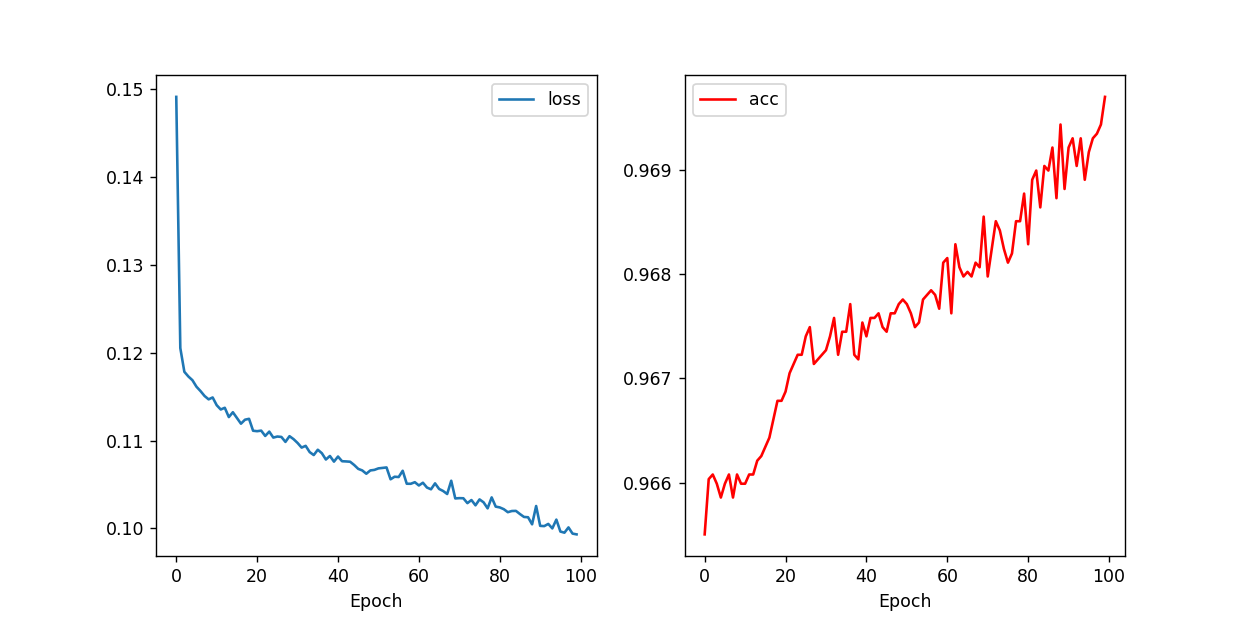

In [20]:
%matplotlib notebook
import matplotlib.pyplot as plt

def plot_history(hist):
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.xlabel('Epoch')
    plt.plot(hist['epoch'], hist['loss'],
           label='loss')
    plt.legend()
    plt.subplot(1,2,2)
    plt.xlabel('Epoch')
    plt.plot(hist['epoch'], hist['acc'],
           label = 'acc',color = 'red')
    plt.legend()
plot_history(hist)

In [21]:
predict = model.predict(test_X)

178/178 [==============================] - 1s 3ms/step


In [22]:
from sklearn.metrics import roc_curve, auc  ###计算roc和auc
def auc_curve(y,prob):
    fpr,tpr,threshold = roc_curve(y,prob) ###计算真正率和假正率
    roc_auc = auc(fpr,tpr) ###计算auc的值
 
    plt.figure(figsize=(5,5))
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.3f)' % roc_auc) ###假正率为横坐标，真正率为纵坐标做曲线
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
 
    plt.show()

<IPython.core.display.Javascript object>


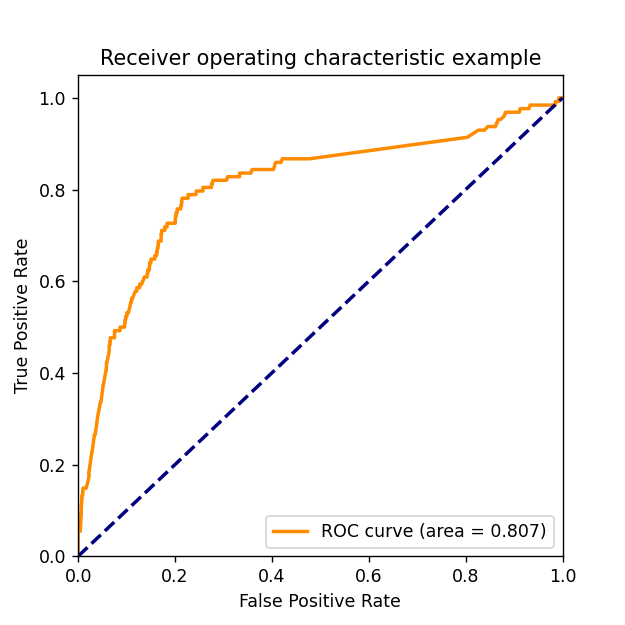

In [23]:
auc_curve(test_Y, predict)

In [24]:
predict.shape

(5678, 1)

In [25]:
test_Y.shape

(5678,)

In [26]:
pred = np.ones((5678,1))
for i in range(predict.shape[0]):
    if predict[i] > 0.5:
        pred[i] = 1
    else:
        pred[i] = 0

In [29]:
from sklearn.metrics import accuracy_score, confusion_matrix
score = accuracy_score(test_Y,pred)
print(score)
score1 = accuracy_score(test_Y, pred, normalize = False)
print(score1)

0.9771046143008102
5548


In [30]:
confusion_matrix = confusion_matrix(test_Y,pred)
confusion_matrix

array([[5541,    9],
       [ 121,    7]], dtype=int64)

In [31]:
count=0
for i in range(test_Y.shape[0]):
    if test_Y[i] == 0:
        count+=1
count / test_Y.shape[0]

0.9774568510038746

In [32]:
test_Y.shape[0] - count

128

In [33]:
count

5550